In [1]:
import warnings
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from dotenv import load_dotenv
from omegaconf import OmegaConf
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from transformer_lens import HookedTransformer, HookedTransformerConfig

sys.path.append(f'{os.getcwd()}/../')
from lm_polygraph.stat_calculators import EntropyCalculator
from prompts import w_context_user_prompt, w_context_system_prompt, wo_context_system_prompt
from utils import heatmap_uncertainty
load_dotenv()

[nltk_data] Downloading package treebank to
[nltk_data]     /home/a.boriskin/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/a.boriskin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
nq_dataset = pd.read_csv('../data/adaptive_rag_natural_questions.csv')
wiki_dataset = pd.read_csv('../data/adaptive_rag_2wikimultihopqa.csv')
hotpot_dataset = pd.read_csv('../data/adaptive_rag_hotpotqa.csv')
musique_dataset = pd.read_csv('../data/adaptive_rag_musique.csv')

nq_dataset_test = pd.read_csv('../data/adaptive_rag_natural_questions_test.csv')
wiki_dataset_test = pd.read_csv('../data/adaptive_rag_2wikimultihopqa_test.csv')
hotpot_dataset_test = pd.read_csv('../data/adaptive_rag_hotpotqa_test.csv')
musique_dataset_test = pd.read_csv('../data/adaptive_rag_musique_test.csv')

In [3]:
cfg = OmegaConf.load("../config.yaml")
device = "cuda:0" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(cfg.model_id)
model = HookedTransformer.from_pretrained(
    cfg.model_id,
    device=device,
    tokenizer=tokenizer,
)
model.set_use_attn_result(True)
model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model meta-llama/Llama-3.2-3B-Instruct into HookedTransformer


HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (blocks): ModuleList(
    (0-27): 28 x TransformerBlock(
      (ln1): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): GroupedQueryAttention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
        (hook_rot_k): HookPoint()
        (hook_rot_q): HookPoint()
      )
      (mlp): GatedMLP(
        (hook_pre): HookPoint()
        (hook_pre_linear): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_att

## Logits Data

In [4]:
# features_list = []
# labels = []
# for dataset, dataset_name in zip(
#         (nq_dataset, wiki_dataset, hotpot_dataset, musique_dataset),
#         ('nq_dataset', 'wiki_multi_dataset', 'hot_pot_dataset', 'musique_dataset')
#     ):
#     print(f'Preproccesing {dataset_name}')
#     for _, row in tqdm(dataset.iterrows(), total=len(dataset)):
        
#         text = tokenizer.apply_chat_template([
#                 {"role": "user", "content": f"question: {row['question']}\nanswer: {row['our_answer_wo_context']}"}, 
#             ], tokenize=False, add_generation_prompt=True)
            
#         tokens = model.to_tokens(text, prepend_bos=False).to(device)
#         with torch.no_grad():
#             # logits = model.run_with_hooks(
#             #     tokens,
#             #     return_type="logits",
#             #     fwd_hooks=[(f"blocks.{i}.hook_resid_post", store_activations(activation_store))
#             #                for i in range(model.cfg.n_layers)]
#             # ) # (1, seq_len, vocab_size)
#             logits = model(tokens) # (1, seq_len, vocab_size)
    
#         logits = logits.detach().cpu()
#         final_logits = logits[:, -1, :].squeeze(dim=0) # (vocab_size)
#         features_list.append(final_logits)
        
#     labels.append(int(row['is_correct_wo_context']))
    
# X = np.stack(features_list) 
# y = np.array(labels)

In [5]:
datasets = [nq_dataset, wiki_dataset, hotpot_dataset, musique_dataset, nq_dataset_test, wiki_dataset_test, hotpot_dataset_test, musique_dataset_test]
dataset_names = ['nq_dataset', 'wiki_multi_dataset', 'hot_pot_dataset', 'musique_dataset', 'nq_dataset_test', 'wiki_dataset_test', 'hotpot_dataset_test', 'musique_dataset_test']

X = torch.empty((sum(len(ds) for ds in datasets), 128256), dtype=torch.float32)
y = torch.empty((sum(len(ds) for ds in datasets),), dtype=torch.int64)

idx = 0
for ds, ds_name in zip(datasets, dataset_names):
    print(f'Preprocessing {ds_name}')
    for _, row in tqdm(ds.iterrows(), total=len(ds)):

        text = tokenizer.apply_chat_template([
            {"role": "user", "content": f"question: {row['question']}\nanswer: {row['our_answer_wo_context']}"}
        ], tokenize=False, add_generation_prompt=True)
        
        tokens = model.to_tokens(text, prepend_bos=False).to(device)
        with torch.no_grad():
            logits = model(tokens)  # (1, seq_len, vocab_size)
        
        final_logits = logits[:, -1, :].squeeze(dim=0) # (vocab_size)
        
        X[idx] = final_logits.cpu()
        y[idx] = int(row['is_correct_wo_context'])
        idx += 1

Preprocessing nq_dataset


100%|██████████| 500/500 [00:41<00:00, 12.04it/s]


Preprocessing wiki_multi_dataset


100%|██████████| 500/500 [00:42<00:00, 11.79it/s]


Preprocessing hot_pot_dataset


100%|██████████| 500/500 [00:42<00:00, 11.86it/s]


Preprocessing musique_dataset


100%|██████████| 500/500 [00:46<00:00, 10.67it/s]


Preprocessing nq_dataset_test


100%|██████████| 500/500 [00:41<00:00, 11.93it/s]


Preprocessing wiki_dataset_test


100%|██████████| 500/500 [00:43<00:00, 11.57it/s]


Preprocessing hotpot_dataset_test


100%|██████████| 500/500 [00:42<00:00, 11.76it/s]


Preprocessing musique_dataset_test


100%|██████████| 500/500 [00:43<00:00, 11.61it/s]


In [6]:
print(X.shape)
print(y.shape)

torch.Size([4000, 128256])
torch.Size([4000])


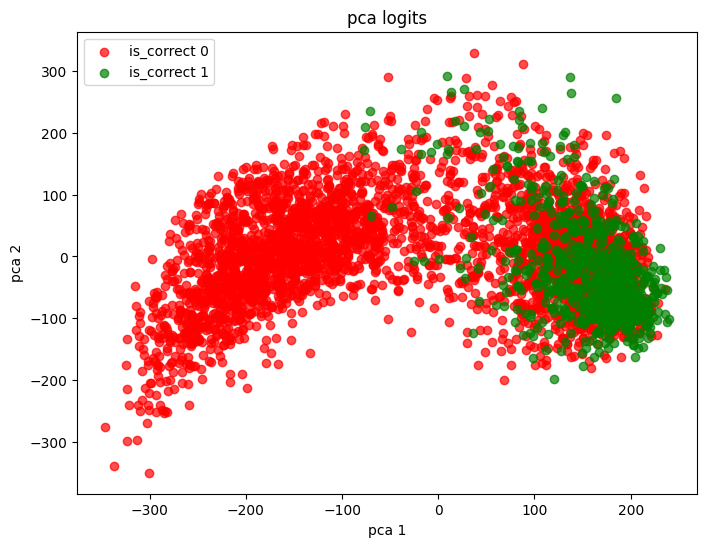

In [7]:
colors = {0: 'red', 1: 'green'}

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
for label in (0, 1):
    idx = (y == label)
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1],
                color=colors[label],
                label=f"is_correct {label}",
                alpha=0.7)
plt.xlabel("pca 1")
plt.ylabel("pca 2")
plt.title("pca logits")
plt.legend()
plt.show()

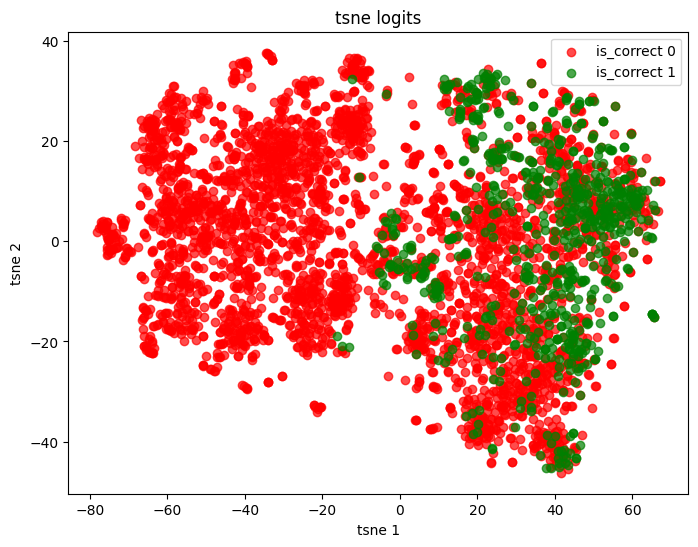

In [8]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
for label in (0, 1):
    idx = (y == label)
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1],
                color=colors[label],
                label=f"is_correct {label}",
                alpha=0.7)
plt.xlabel("tsne 1")
plt.ylabel("tsne 2")
plt.title("tsne logits")
plt.legend()
plt.show()

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [11]:
def y_proportion(tensor):
    values, counts = torch.unique(tensor, return_counts=True)
    total_elements = tensor.numel()
    proportions = counts.float() / total_elements
    return proportions

print(y_proportion(y))
print(y_proportion(y_train))
print(y_proportion(y_test))

tensor([0.8240, 0.1760])
tensor([0.8272, 0.1728])
tensor([0.8112, 0.1887])


In [12]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       649
           1       0.54      0.53      0.54       151

    accuracy                           0.83       800
   macro avg       0.72      0.71      0.72       800
weighted avg       0.83      0.83      0.83       800



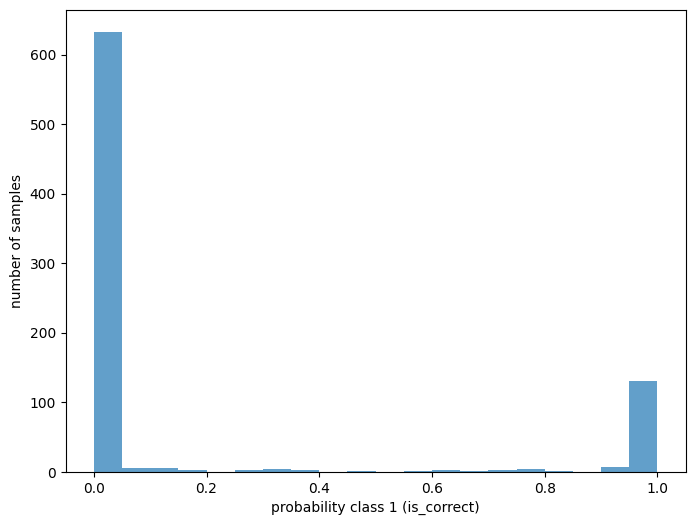

In [13]:
probs = clf.predict_proba(X_test)[:, 1]

plt.figure(figsize=(8, 6))
plt.hist(probs, bins=20, alpha=0.7,)
plt.xlabel('probability class 1 (is_correct)')
plt.ylabel('number of samples')
plt.show()

## QA inference

In [15]:

    

# pred_class = classifier.predict(final_logits.reshape(1, -1))[0]

# if pred_class == 0:
#     final_answer = row['our_answer_w_context']
# else:
#     final_answer = row['our_answer_wo_context']
